# 앙상블

- 여러개의 분류 모델을 조합하여 더 나은 성능을 낼 수 있게 하는 방법

#### 앙상블 - 백지장도 맞들면 낫다

http://yann.lecun.com/exdb/mnist/

- train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
- train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
- t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
- t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

In [2]:
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score # 교차검증 빠짐없이 검증을 함

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(5)

### 손글씨 데이터 호출

In [4]:
mnist = datasets.load_digits()

features, labels = mnist.data, mnist.target

features, labels

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([0, 1, 2, ..., 8, 9, 8]))

In [10]:
len(features), len(labels)

(1797, 1797)

# 교차 검증

In [11]:
# %%writtefile cross_validation.py  저장 시
# from cross_validation import cross_validation 호출시
# C:/Users/로그온계정명/AppData/Local/Programs/Python/Python39/Lib/cross_validation 에 저장


# 10번의 교차검증 수행

def cross_validation(classifier, features, labels): # 분류기, 테스트데이터, 정답데이터
    cv_scores = []
    
    for i in range(10):
        scores = cross_val_score(classifier, features, labels,
                                cv = 10, # 트리구조에서 10개로 분할 
                                scoring = 'accuracy')
        cv_scores.append(scores.mean())
        
    return cv_scores

mnist 손글씨 검증 정확도

In [14]:
# 의사결정나무로 작업
dt_cv_scores = cross_validation(tree.DecisionTreeClassifier(), features, labels)
dt_cv_scores

[0.8296958410924891,
 0.819137181874612,
 0.8285878336436996,
 0.8274736188702668,
 0.8280446927374301,
 0.8319304779639974,
 0.8308162631905649,
 0.8230446927374302,
 0.8269056486654252,
 0.8280229671011794]

In [16]:
# 랜덤포레스트로 작업
rf_cv_scores = cross_validation(RandomForestClassifier(), features, labels)
rf_cv_scores

[0.9504655493482307,
 0.9410117939168219,
 0.9510211049037863,
 0.9549162011173185,
 0.9504469273743016,
 0.9449130974549969,
 0.9510117939168218,
 0.9493513345747981,
 0.9488081936685286,
 0.9471198013656114]

# 검증결과 시각화 : dt & rf

In [21]:
cv_list = [
    ['random_forest', rf_cv_scores],
    ['decision_tree', dt_cv_scores]
]

df = pd.DataFrame.from_dict(dict(cv_list))
df

,random_forest,decision_tree
0,0.950466,0.829696
1,0.941012,0.819137
2,0.951021,0.828588
3,0.954916,0.827474
4,0.950447,0.828045
5,0.944913,0.831930
6,0.951012,0.830816
7,0.949351,0.823045
8,0.948808,0.826906
9,0.947120,0.828023


<AxesSubplot:>

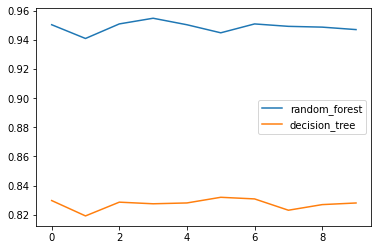

In [27]:
df.plot() # 정확도는 랜덤포레스트가 훨씬 높음

In [28]:
# 의사결정나무 정확도
np.mean(dt_cv_scores)

0.8273659217877096

In [29]:
# 랜덤포레스트 정확도
np.mean(rf_cv_scores)

0.9489065797641215

# ----------------------------------------------------------

# SVM 으로 손글씨 데이터 분류

# mnist-download

In [1]:
import urllib.request as req
import gzip, os, os.path

savepath = "./mnist"
baseurl = "http://yann.lecun.com/exdb/mnist"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"]

# 다운로드
if not os.path.exists(savepath): os.mkdir(savepath)
for f in files:
    url = baseurl + "/" + f
    loc = savepath + "/" + f
    print("download:", url)
    if not os.path.exists(loc):
        req.urlretrieve(url, loc)

# GZip 압축 해제
for f in files:
    gz_file = savepath + "/" + f
    raw_file = savepath + "/" + f.replace(".gz", "")
    print("gzip:", f)
    with gzip.open(gz_file, "rb") as fp:
        body = fp.read()
        with open(raw_file, "wb") as w:
            w.write(body)
print("ok")


download: http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
download: http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
download: http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
download: http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
gzip: train-images-idx3-ubyte.gz
gzip: train-labels-idx1-ubyte.gz
gzip: t10k-images-idx3-ubyte.gz
gzip: t10k-labels-idx1-ubyte.gz
ok


## mnist-tocsv

In [3]:
import struct
def to_csv(name, maxdata):
    # 레이블 파일과 이미지 파일 열기
    lbl_f = open("./mnist/"+name+"-labels-idx1-ubyte", "rb")
    img_f = open("./mnist/"+name+"-images-idx3-ubyte", "rb")
    csv_f = open("./mnist/"+name+".csv", "w", encoding="utf-8")
    # 헤더 정보 읽기 --- (※1)
    mag, lbl_count = struct.unpack(">II", lbl_f.read(8))
    mag, img_count = struct.unpack(">II", img_f.read(8))
    rows, cols = struct.unpack(">II", img_f.read(8))
    pixels = rows * cols
    # 이미지 데이터를 읽고 CSV로 저장하기 --- (※2)
    res = []
    for idx in range(lbl_count):
        if idx > maxdata: break
        label = struct.unpack("B", lbl_f.read(1))[0]
        bdata = img_f.read(pixels)
        sdata = list(map(lambda n: str(n), bdata))
        csv_f.write(str(label)+",")
        csv_f.write(",".join(sdata)+"\r\n")
        # 잘 저장됐는지 이미지 파일로 저장해서 테스트하기 -- (※3)
        if idx < 10:
            s = "P2 28 28 255\n"
            s += " ".join(sdata)
            iname = "./mnist/{0}-{1}-{2}.pgm".format(name,idx,label)
            with open(iname, "w", encoding="utf-8") as f:
                f.write(s)
    csv_f.close()
    lbl_f.close()
    img_f.close()
    
# 결과를 파일로 출력하기 --- (※4)
#to_csv("train", 1000)
to_csv("train", 60000)
to_csv("t10k", 10000)


# mnist-train

In [ ]:
from sklearn import model_selection, svm, metrics

# CSV 파일을 읽어 들이고 가공하기 --- (※1)
def load_csv(fname):
    labels = []
    images = []
    with open(fname, "r") as f:
        for line in f:
            cols = line.split(",")
            if len(cols) < 2: continue
            labels.append(int(cols.pop(0)))
            vals = list(map(lambda n: int(n) / 256, cols))
            images.append(vals)
    return {"labels":labels, "images":images}
data = load_csv("./mnist/train.csv")
test = load_csv("./mnist/t10k.csv")

# 학습하기 --- (※2)
clf = svm.SVC()
clf.fit(data["images"], data["labels"])

# 예측하기 --- (※3)
predict = clf.predict(test["images"])

# 결과 확인하기 --- (※4)
ac_score = metrics.accuracy_score(test["labels"], predict)
cl_report = metrics.classification_report(test["labels"], predict)
print("정답률 =", ac_score)
print("리포트 =")
print(cl_report)
